<a href="https://colab.research.google.com/github/ayeshagunarathne/Transfer-Learning/blob/main/Image_classification_using_pretrained_vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**TASK 1: brain tumor classification  using pretrained vision transformer base model(Vit-base) from torchvision.models to check how well it perform on medical image classification tasks.**

#### **TASK 2: MedVit pretrained model is used for the classification same brain MRI dataset.**


## **Helper Functions**

In [2]:
#Reference for this code section : https://www.learnpytorch.io/08_pytorch_paper_replicating/
#Setting up helper fucntions needed for the code
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 24.21 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


## **Getting the dataset**

About Dataset: This Dataset can be accessed here -> https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

This is a MRI image dataset used to classify brain tumors into 4 classes as : 'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor

In [3]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 15.87 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [4]:
!pwd

/content


In [5]:
# Setup directory paths to train and test images
train_dir = "/content/Brain-Tumor-Classification-DataSet/Training"
test_dir = "/content/Brain-Tumor-Classification-DataSet/Testing"
train_dir, test_dir

('/content/Brain-Tumor-Classification-DataSet/Training',
 '/content/Brain-Tumor-Classification-DataSet/Testing')

In [6]:
#Setting up device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **ViT base model as a feature extractor**

By turning the pretrained ViT-Base into a feature extractor, we take advantage of its powerful learned features while minimizing the need for extensive training on our dataset

Here we will use the pretrained ViT-Base with patch size 16x16 from **torchvision.models** and prepare it for our dataset by turning it into a **feature extractor transfer learning model**.



The pretrained weigths of the Vit base model is obtained and then the transforms applied to the original dataset of the pretrained model is obtained and used on our dataset

In [7]:
# Getting pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

#Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 84.3MB/s]


In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=64) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

print(f"Train dataloader: {train_dataloader_pretrained}\nTest dataloader: {test_dataloader_pretrained}\nClass names: {class_names}")

Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f5055f3fee0>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f4f79fefa30>
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [141]:
#Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False



# Change the classifier head and the convolution layer (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.conv_proj = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=(16, 16), stride=(16, 16))
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [142]:
summary(model=pretrained_vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         # col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 1

## **Training the classifier model**

In [143]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3584 | train_acc: 0.3797 | test_loss: 1.5471 | test_acc: 0.2763
Epoch: 2 | train_loss: 1.1273 | train_acc: 0.5291 | test_loss: 1.7529 | test_acc: 0.2406
Epoch: 3 | train_loss: 1.0243 | train_acc: 0.5503 | test_loss: 1.7095 | test_acc: 0.3518
Epoch: 4 | train_loss: 0.9688 | train_acc: 0.5926 | test_loss: 1.7886 | test_acc: 0.3509
Epoch: 5 | train_loss: 0.9304 | train_acc: 0.6176 | test_loss: 1.8582 | test_acc: 0.3754
Epoch: 6 | train_loss: 0.9209 | train_acc: 0.6249 | test_loss: 1.7779 | test_acc: 0.3643
Epoch: 7 | train_loss: 0.8960 | train_acc: 0.6403 | test_loss: 1.8105 | test_acc: 0.3754
Epoch: 8 | train_loss: 0.8890 | train_acc: 0.6357 | test_loss: 1.8281 | test_acc: 0.3911
Epoch: 9 | train_loss: 0.8870 | train_acc: 0.6425 | test_loss: 1.8253 | test_acc: 0.3687
Epoch: 10 | train_loss: 0.8659 | train_acc: 0.6467 | test_loss: 1.9714 | test_acc: 0.3710


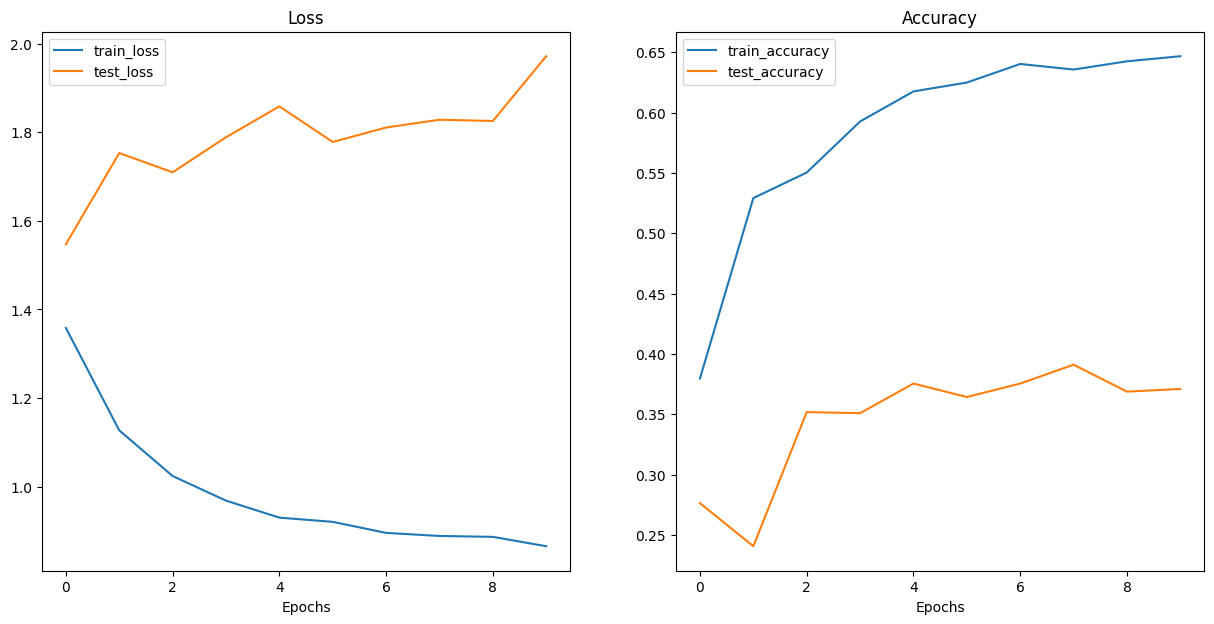

In [144]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## **WHY VIT BASE MODEL IS NOT PERFORMING WELL ON OUR DATASET?**

The Vit_b model is trained on a dataset which different from medical domain.Hence the model fail to generalize into MRI images in our dataset.

Few solutions are to:unfreeze few more layers of the pretrained model or to train for more epochs or to use a pretrained model designed specifically for medical image classifications(ex:MedVit)


## **TASK 2: MedVit model for Transfer Learning**

Pre-trained MedVit models can be accessed here - https://github.com/Omid-Nejati/MedViT

The reference document for importing model : https://github.com/Omid-Nejati/MedViT/blob/main/Colab_MedViT.ipynb

For this tutorial MedVit small model is used.


**WILL UPDATE TASK 2 SOON!**




